In [1]:
import torch
from torch.utils.data import DataLoader
import pickle
import numpy as np

In [2]:
model_type = "conversation" # abc or conversation
device = "mps"

In [3]:
with open(f"../data/clean/{model_type}_train.pkl", "rb") as f:
    train = pickle.load(f)

with open(f"../data/clean/{model_type}_test.pkl", "rb") as f:
    test = pickle.load(f)

train_tensors = []
for i in train:
    train_tensors.append({
        "data": torch.tensor(i["data"]).float(),
        "label": torch.tensor(i["label"]).long()
    })

test_tensors = []
for i in test:
    test_tensors.append({
        "data": torch.tensor(i["data"]).float(),
        "label": torch.tensor(i["label"]).long()
    })

train_loader = DataLoader(train_tensors, batch_size=32, shuffle=True)
test_loader = DataLoader(test_tensors, batch_size=32, shuffle=True)

In [4]:
with open(f"../data/model/{model_type}_id2label.pkl", "rb") as f:
    id2label = pickle.load(f)

id2label

{0: 'yes',
 1: 'no',
 2: 'hello',
 3: 'bye',
 4: 'how',
 5: 'old',
 6: 'you',
 7: 'me',
 8: 'explore',
 9: 'deaf',
 10: 'good',
 11: 'bad'}

In [5]:
from PointNet import PointNet

num_classes = len(id2label)
print(f"Instantiating model with {num_classes} classes")
pointnet = PointNet(classes=num_classes, device=device)

Instantiating model with 12 classes


In [6]:
from sklearn.metrics import accuracy_score

checkpoint_path = f"../data/model/{model_type}.pth"

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1).to(device)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1).to(device)
    diff3x3 = id3x3 - torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64 - torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        print_every_x = 16
        for i, data in enumerate(train_loader, 0):
            inputs = data['data'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_every_x == print_every_x - 1:
                print(f"[Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / print_every_x:.4f}]")
                running_loss = 0.0

        model.eval()
        # validation
        total = correct = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data['data'].to(device).float(), data['label'].to(device)
                outputs, _, _ = model(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'Accuracy: {100 * correct / total:.2f}%')

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)
train(pointnet, train_loader, test_loader, epochs=10)
# torch.save(pointnet.state_dict(), checkpoint_path)

[Epoch: 1, Batch: 16, Loss: 2.0766]
[Epoch: 1, Batch: 32, Loss: 1.2123]
[Epoch: 1, Batch: 48, Loss: 0.7856]
Accuracy: 96.25%
[Epoch: 2, Batch: 16, Loss: 0.3978]
[Epoch: 2, Batch: 32, Loss: 0.3208]
[Epoch: 2, Batch: 48, Loss: 0.3103]
Accuracy: 98.33%
[Epoch: 3, Batch: 16, Loss: 0.2215]
[Epoch: 3, Batch: 32, Loss: 0.2509]
[Epoch: 3, Batch: 48, Loss: 0.2399]
Accuracy: 94.79%
[Epoch: 4, Batch: 16, Loss: 0.1560]
[Epoch: 4, Batch: 32, Loss: 0.1916]
[Epoch: 4, Batch: 48, Loss: 0.1618]
Accuracy: 98.33%
[Epoch: 5, Batch: 16, Loss: 0.1450]
[Epoch: 5, Batch: 32, Loss: 0.1507]
[Epoch: 5, Batch: 48, Loss: 0.1704]
Accuracy: 98.54%
[Epoch: 6, Batch: 16, Loss: 0.1583]
[Epoch: 6, Batch: 32, Loss: 0.1177]
[Epoch: 6, Batch: 48, Loss: 0.0883]
Accuracy: 98.33%
[Epoch: 7, Batch: 16, Loss: 0.1247]
[Epoch: 7, Batch: 32, Loss: 0.1168]
[Epoch: 7, Batch: 48, Loss: 0.1055]
Accuracy: 99.38%
[Epoch: 8, Batch: 16, Loss: 0.0890]
[Epoch: 8, Batch: 32, Loss: 0.1148]
[Epoch: 8, Batch: 48, Loss: 0.0910]
Accuracy: 98.75%


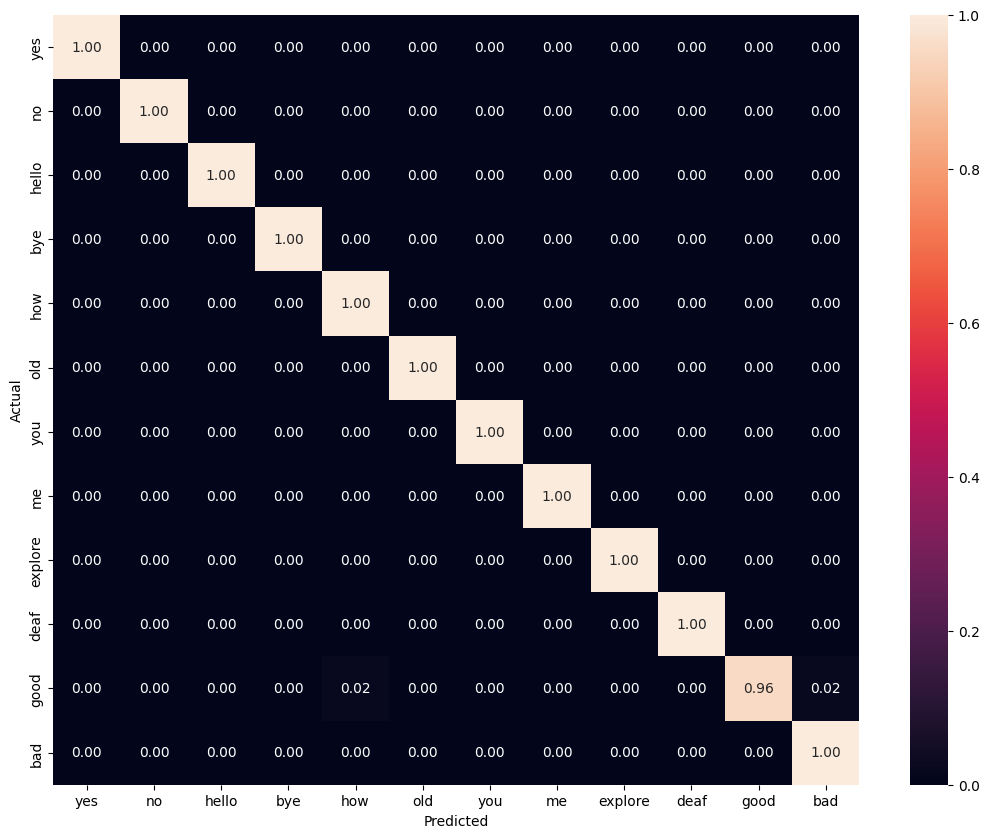

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pointnet = PointNet(classes=num_classes, device="cpu")
pointnet.load_from_pth(checkpoint_path)
pointnet.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data['data'].float(), data['label'].long()
        outputs, _, _ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += preds.numpy().tolist()
        all_labels += labels.numpy().tolist()
    
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(13,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()